# DETR Visualization of Decoder Attention Weights

In this notebook, we will visualize decoder attention maps obtained from DETR. We try several combinations of the model, including:
1. Original configuration
2. Decoder only + Global Fully-Connected (FC) layer, with three experiment setups for the first several epochs of training.
3. Decoder only + Local FC layer
4. Attention Maps last stage + Global FC layer

## Content

* [CASIA-Webface](#1)
* [Masked-LFW](#2)

In [1]:
# run this cell only once
import os
os.chdir("..")

In [2]:
from collections import defaultdict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torchvision import transforms

from eval_net import extract_feature
from config.config_parser import get_default_cfg, merge_cfg_from_file, \
    get_dataloader_from_cfg, get_model_from_cfg, get_parameters_from_cfg

In [118]:
experiments = {
    0 : "Original",
    1 : "Decoder only",
    2 : "Decoder only exp 1",
    3 : "Decoder only exp 2",
    4 : "Decoder only exp 3",
    5 : "Decoder only + Local FC",
    6 : "Last stage + Decoder only"
}

vis = 6 # change to 0, 1, 2, 3, 4, 5, 6 

In [119]:
if experiments[vis] == "Original":
    config_file = "pretrained_weight/DETR_queries_64_CASIA/config.yaml"
    weight = "pretrained_weight/DETR_queries_64_CASIA/best.pt"
    mcp_weight = "pretrained_weight/DETR_queries_64_CASIA/mcp_best.pt"
    save_dir = "visualization/DETR_Original/"
    
elif experiments[vis] == "Decoder only":
    config_file = "pretrained_weight/DETR_queries_64_CASIA_decoder_only/config.yaml"
    weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only/best.pt"
    mcp_weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only/mcp_best.pt"
    save_dir = "visualization/DETR_decoder_only_best/"
    
elif experiments[vis] == "Decoder only exp 1":
    config_file = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_first_epoch_exp_1/config.yaml"
    weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_first_epoch_exp_1/epoch_1.pt"
    mcp_weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_first_epoch_exp_1/mcp_epoch_1.pt"
    save_dir = "visualization/DETR_decoder_only_exp_1/"

elif experiments[vis] == "Decoder only exp 2":
    config_file = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_first_epoch_exp_2/config.yaml"
    weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_first_epoch_exp_2/epoch_6.pt"
    mcp_weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_first_epoch_exp_2/mcp_epoch_6.pt"
    save_dir = "visualization/DETR_decoder_only_exp_2/"
    
elif experiments[vis] == "Decoder only exp 3":
    config_file = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_first_epoch_exp_3/config.yaml"
    weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_first_epoch_exp_3/epoch_1.pt"
    mcp_weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_first_epoch_exp_3/mcp_epoch_1.pt"
    save_dir = "visualization/DETR_decoder_only_exp_3/"
    
elif experiments[vis] == "Decoder only + Local FC":
    config_file = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_local_fc/config.yaml"
    weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_local_fc/best.pt"
    mcp_weight = "pretrained_weight/DETR_queries_64_CASIA_decoder_only_local_fc/mcp_best.pt"
    save_dir = "visualization/DETR_decoder_only_local_fc/"

elif experiments[vis] == "Last stage + Decoder only":
    config_file = "pretrained_weight/DETR_queries_64_CASIA_last_decoder_only/config.yaml"
    weight = "pretrained_weight/DETR_queries_64_CASIA_last_decoder_only/last.pt"
    mcp_weight = "pretrained_weight/DETR_queries_64_CASIA_last_decoder_only/mcp_last.pt"
    save_dir = "visualization/DETR_last_decoder_only/"
    
dataset_name = "casia"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [120]:
# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [dataset_name] 
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [""] # No need test set
cfg["SOLVER"]["BATCH_SIZE"] = 1

# get model and dataloader
model, classifier, _ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))
model.eval()

classifier.load_state_dict(torch.load(mcp_weight))
classifier.eval()

# freeze parameters
for p in model.parameters():
    p.requires_grad = False
    
for p in classifier.parameters():
    p.requires_grad = False
    
num_images, data_loaders, *_ = get_dataloader_from_cfg(cfg)
data_loader_iter = iter(data_loaders[0])

<a name='1'> </a>
## 1. CASIA-Webface

In [121]:
def predict(model, classifier, image, label, device = 'cuda'):
    model.to(device)
    classifier.to(device)
    
    conv_features, dec_attn_weights = [], []
    
    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    image, label = image.to(device), label.to(device)
    outputs = model(image)
    feature, additional_loss, additional_output = model(image)
    
    score = classifier(feature["features"], label)
    score_prob = F.softmax(score, dim = 1)
    pred = torch.max(score_prob, dim = 1).indices.to("cpu")
    
    for hook in hooks:
        hook.remove()

    conv_features = conv_features[0]
    dec_attn_weights = dec_attn_weights[0]
    
    return pred, conv_features, dec_attn_weights

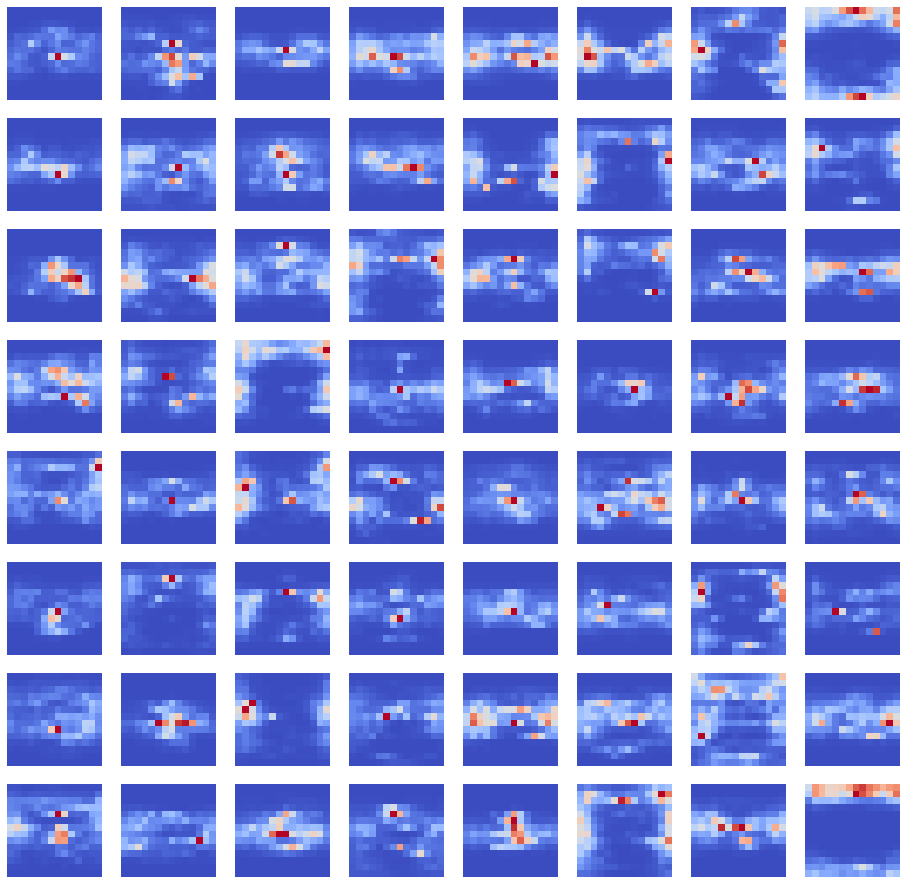

Ground truth: 2730
Prediction: 2730


In [122]:
to_PIL = transforms.Compose([
    transforms.Normalize(mean = (0, 0, 0), std = (1/0.5, 1/0.5, 1/0.5)),
    transforms.Normalize(mean = (-0.5, -0.5, -0.5), std = (1, 1, 1)),
    transforms.ToPILImage()
])

data, label = next(data_loader_iter)
img = to_PIL(torch.squeeze(data.detach().clone()))

# make predictions
pred, *outputs = predict(model, classifier, data, label, device = device)
h, w = outputs[0]['0'].tensors.shape[-2:]
dec_attn_weights = torch.squeeze(outputs[-1]).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(8,8, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(len(ax)):
    sns.heatmap(dec_attn_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = False)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

print(f"Ground truth: {label.item()}")

try:
    print(f"Prediction: {pred.item()}")
except:
    print(f"Predictions: {pred}")

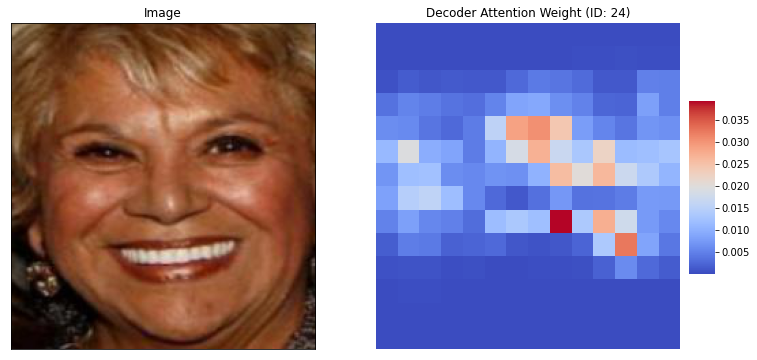

In [123]:
idx = 24

fig, ax = plt.subplots(1,2, figsize = (12,6))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax[0].imshow(img, aspect = "auto")
ax[0].set_title("Image")

sns.heatmap(dec_attn_weights[idx].reshape(h, w), cmap = "coolwarm", ax = ax[1], cbar = True, cbar_ax = cbar_ax)
ax[1].set_title(f"Decoder Attention Weight (ID: {idx})")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "one_sample_prediction_CASIA.jpg"))

## 2. Masked LFW

In [124]:
dataset_name = "lfw_masked"
device = "cuda" if torch.cuda.is_available() else "cpu"

# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [""] 
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [dataset_name] # No need test set
cfg["SOLVER"]["BATCH_SIZE"] = 1
_, test_root, test_images, test_annot = get_parameters_from_cfg(cfg)["TEST"][0]

# get model and dataloader
model, classifier, _ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))
model.eval()

classifier.load_state_dict(torch.load(mcp_weight))
classifier.eval()

# freeze parameters
for p in model.parameters():
    p.requires_grad = False
    
for p in classifier.parameters():
    p.requires_grad = False

In [125]:
def read_pairs(root, filelist):
    with open(os.path.join(root, filelist), 'r') as f:
        pairs_lines = f.readlines()[:]
    
    return pairs_lines


def get_pairs_images(pair_line, file_ext = ''):
    pair_line = pair_line.replace('\n', '').split()
  
    if len(pair_line) == 3:
        flag = True
        if os.path.splitext(pair_line[0])[1] in ['.jpg', '.png'] and os.path.splitext(pair_line[1])[1] in ['.jpg', '.png']:
            filename1 = pair_line[0]
            filename2 = pair_line[1]
            flag = pair_line[-1] == '1'
        else:
            # same identity
            fileid1 = '0' * (4 - len(str(pair_line[1])) ) + str(pair_line[1])
            fileid2 = '0' * (4 - len(str(pair_line[2])) ) + str(pair_line[2])
            filename1 = f'{pair_line[0]}_' + fileid1 + file_ext + '.jpg'
            filename2 = f'{pair_line[0]}_' + fileid2 + file_ext + '.jpg'
    elif len(pairs) == 4:
        # different identity
        flag = False
        fileid1 = '0' * (4 - len(str(pair_line[1])) ) + str(pair_line[1])
        fileid2 = '0' * (4 - len(str(pair_line[3])) ) + str(pair_line[3])
        filename1 = f'{pair_line[0]}_' + fileid1 + file_ext + '.jpg'
        filename2 = f'{pair_line[2]}_' + fileid2 + file_ext + '.jpg'
        
    return filename1, filename2, flag


def get_masked_pairs(pair_line, file_ext = ''):
    pair_line = pair_line.replace('\n', '').split()
    mask_exist = False
    
    masked_file = ori_file = pair_line[1]
    if masked_file.split('_')[-1] in ['cloth.jpg', 'KN95.jpg', 'N95.jpg']:
        ori_file = '_'.join(masked_file.split('_')[:-1]) + '.jpg'
        mask_exist = True
        
    return ori_file, masked_file, mask_exist


def predict(model, image, device = 'cpu'):
    model.to(device)
    model.eval()
    
    conv_features, dec_attn_weights = [], []
    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]
    
    image = image.to(device)
    
    with torch.no_grad():
        _ = model(image)
        
    for hook in hooks:
        hook.remove()

    conv_features = conv_features[0]
    dec_attn_weights = dec_attn_weights[0]
    
    
    return conv_features, dec_attn_weights
        
        
# define transformation
transform_face = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

pairs = read_pairs(test_root, test_annot)

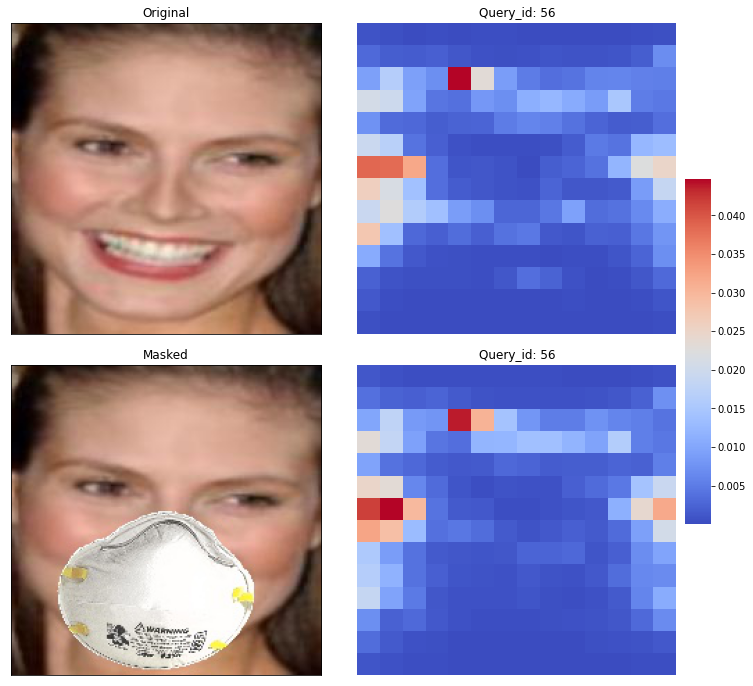

Cosine similarity 0.49571678042411804


In [126]:
sample_idx = 2288 # np.random.randint(len(pairs), size = 1)[0] 

sample_pairs = pairs[sample_idx]
filename1, filename2, _= get_masked_pairs(sample_pairs)

img1 = Image.open(os.path.join(test_root, test_images, filename1)).convert('RGB')
img2 = Image.open(os.path.join(test_root, test_images, filename2)).convert('RGB')

tensor_img1 = transform_face(img1).unsqueeze(0)
tensor_img2 = transform_face(img2).unsqueeze(0)

conv_features, dec_attn_weights = predict(model, tensor_img1, device = device)
conv_features2, dec_attn_weights2 = predict(model, tensor_img2, device = device)

weights = torch.squeeze(dec_attn_weights).to("cpu").numpy()
m_weights = torch.squeeze(dec_attn_weights2).to("cpu").numpy()


# visualize the result
h, w = conv_features['0'].tensors.shape[-2:]
idx = 56 #change from 1 - 64

imgs = [img1, img2]
titles = ["Original", "Masked"]
weights_vis = [weights[idx], m_weights[idx]]

fig, ax = plt.subplots(2,2, figsize = (12,12))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax = ax.flat

for i in range(len(ax)):
    if i % 2 == 0:
        # visualize face image
        ax[i].imshow(imgs[i // 2])
        ax[i].set_title(titles[i // 2])
    else:
        sns.heatmap(weights_vis[i // 2].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = i == 1, cbar_ax = cbar_ax if i == 1 else None)
        ax[i].set_title(f"Query_id: {idx}")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
plt.show()

# Compute similarity
feature1 = extract_feature(img1, model, device = device)
feature2 = extract_feature(img2, model, device = device)
cosine_dist = feature1.dot(feature2) / (feature1.norm() * feature2.norm() + 1e-5)

print("Cosine similarity", cosine_dist.item())
fig.savefig(os.path.join(save_dir, "single_pair_Masked-LFW.jpg"))

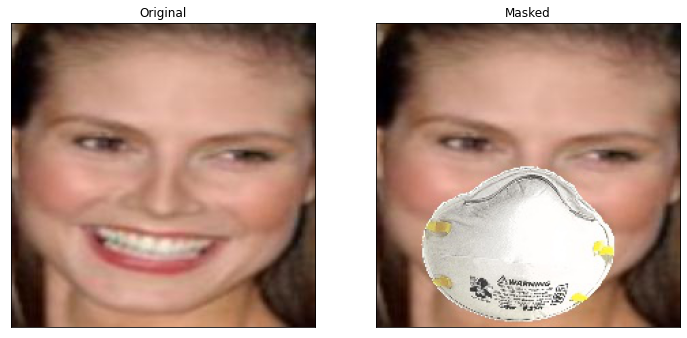

In [127]:
fig, ax = plt.subplots(1,2, figsize = (12,24))
ax = ax.flat

imgs = [img1, img2]
titles = ["Original", "Masked"]

for i in range(len(ax)):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()
# fig.savefig(f"visualization/DETR_experiment.jpg")

<a name='2.1'> </a>
### 2.1. Transformer Decoder Visualization (Original Faces)

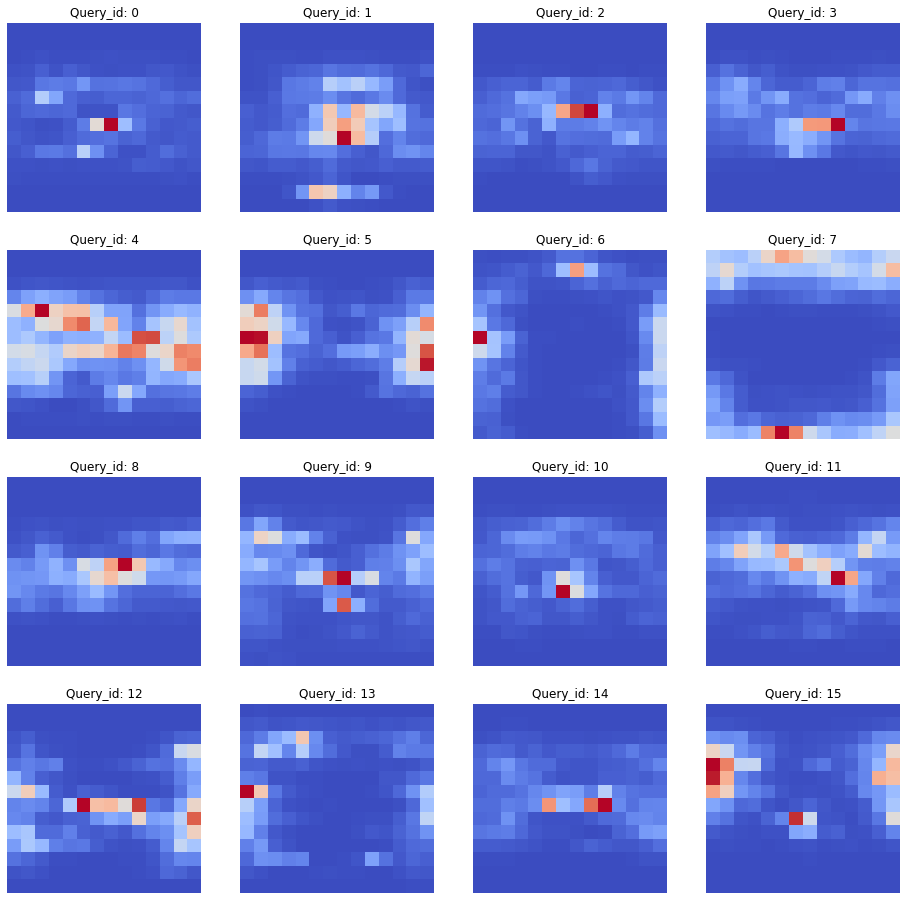

In [128]:
# id 0 - 16
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(16):
    sns.heatmap(weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = False)
    ax[i].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_0_15.jpg"))

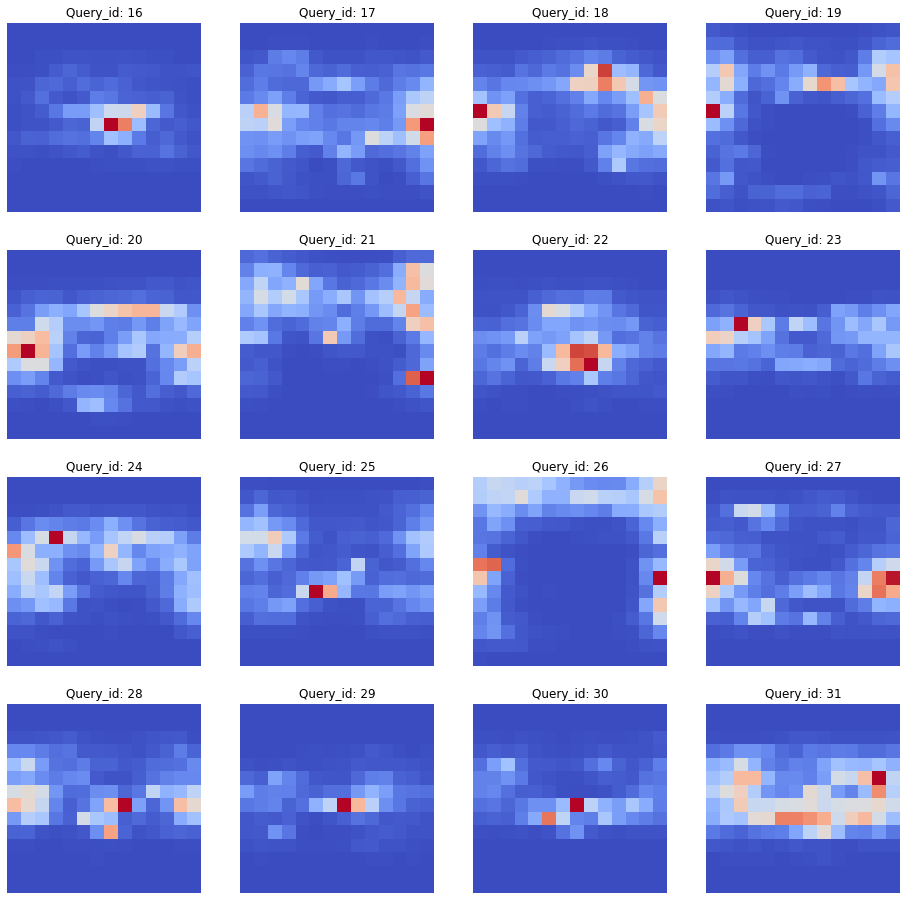

In [129]:
# id 16 - 31
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(16, 32):
    sns.heatmap(weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-16], cbar = False)
    ax[i-16].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_16_31.jpg"))

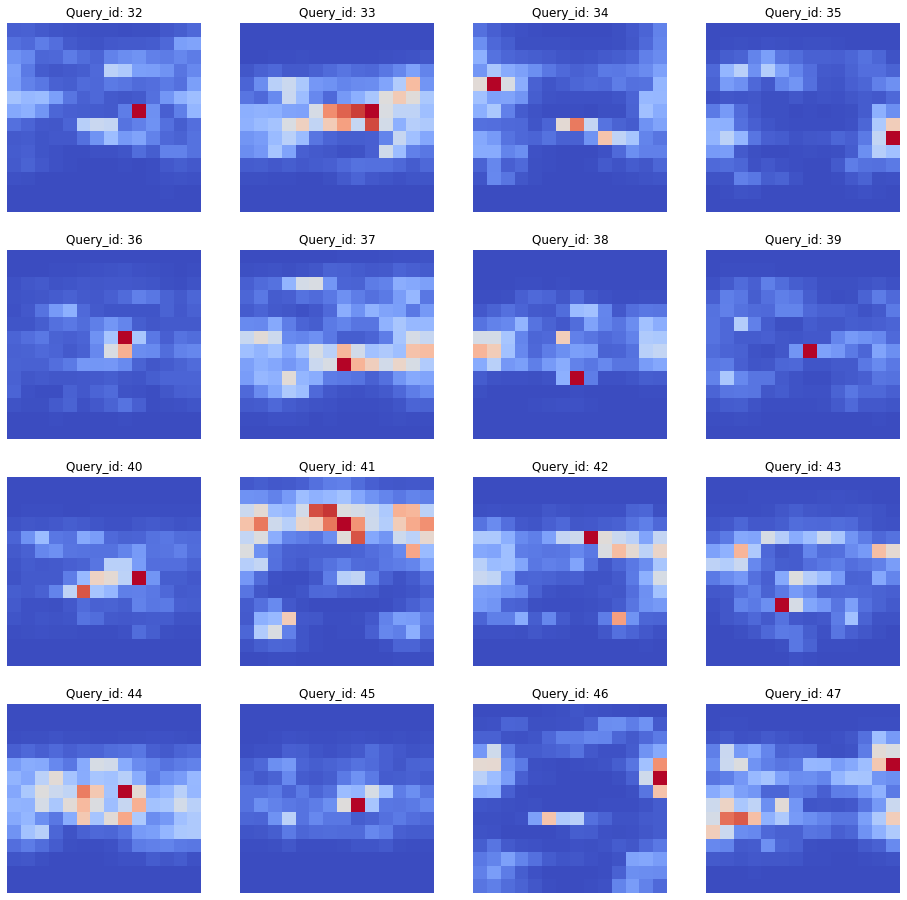

In [130]:
# id 32 - 47
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(32, 48):
    sns.heatmap(weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-32], cbar = False)
    ax[i-32].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_32_47.jpg"))

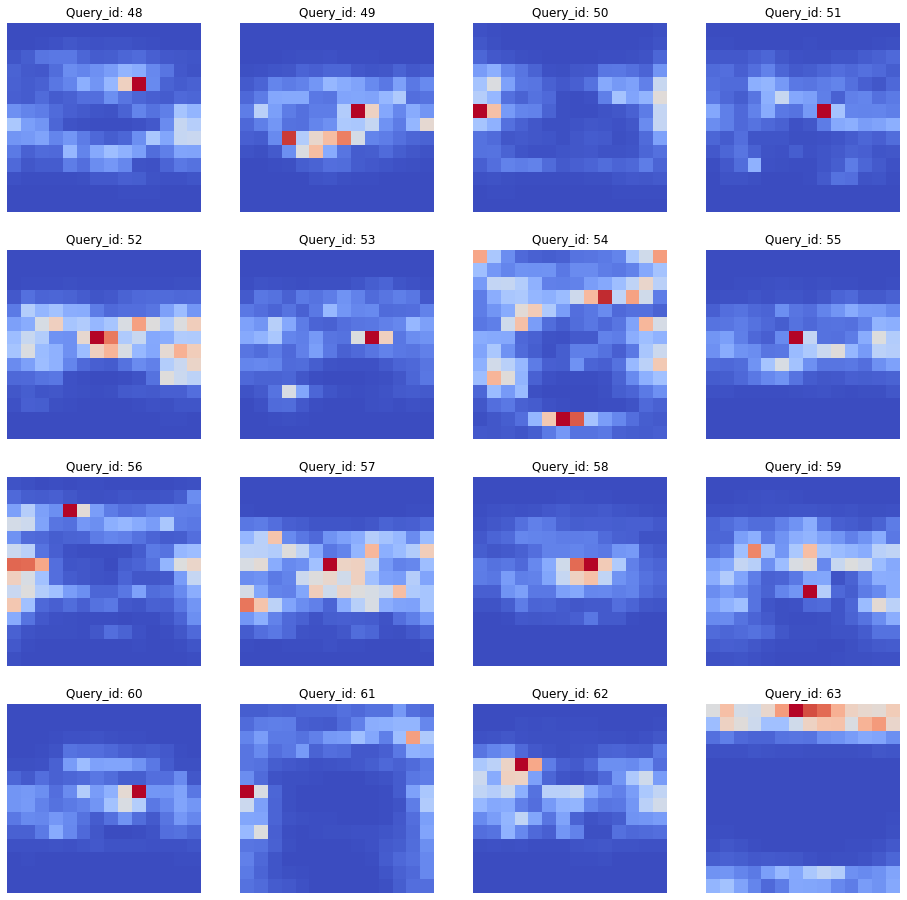

In [131]:
# id 48 - 63
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(48, 64):
    sns.heatmap(weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-48], cbar = False)
    ax[i-48].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_48_63.jpg"))

<a name='2.2'> </a>
### 2.2. Transformer Decoder Visualization (Masked Faces)

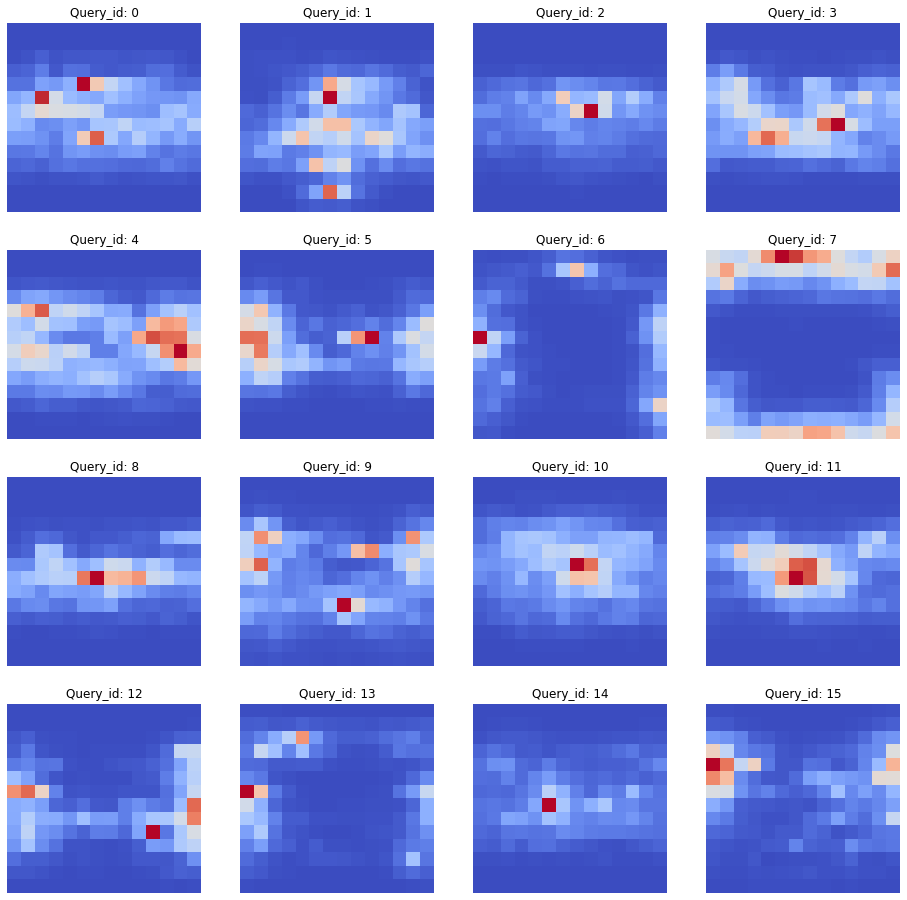

In [132]:
# id 0 - 15
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(16):
    sns.heatmap(m_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = False)
    ax[i].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_masked_0_15.jpg"))

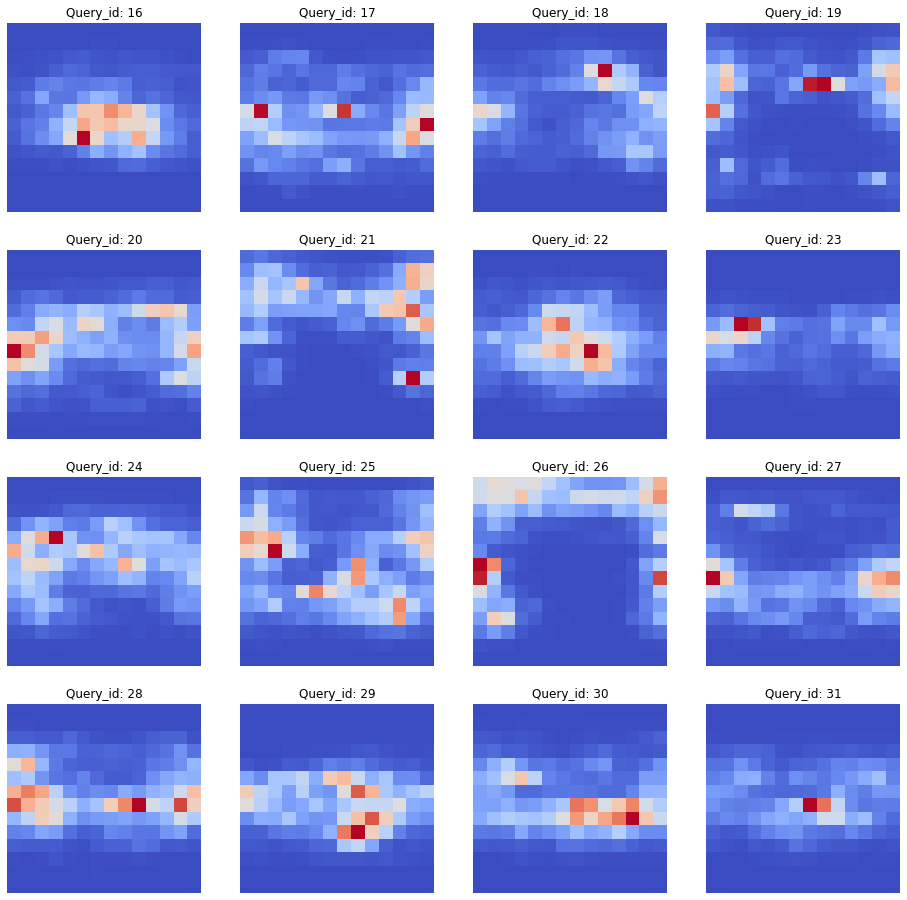

In [133]:
# id 16 - 31
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(16, 32):
    sns.heatmap(m_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-16], cbar = False)
    ax[i-16].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_masked_16_31.jpg"))

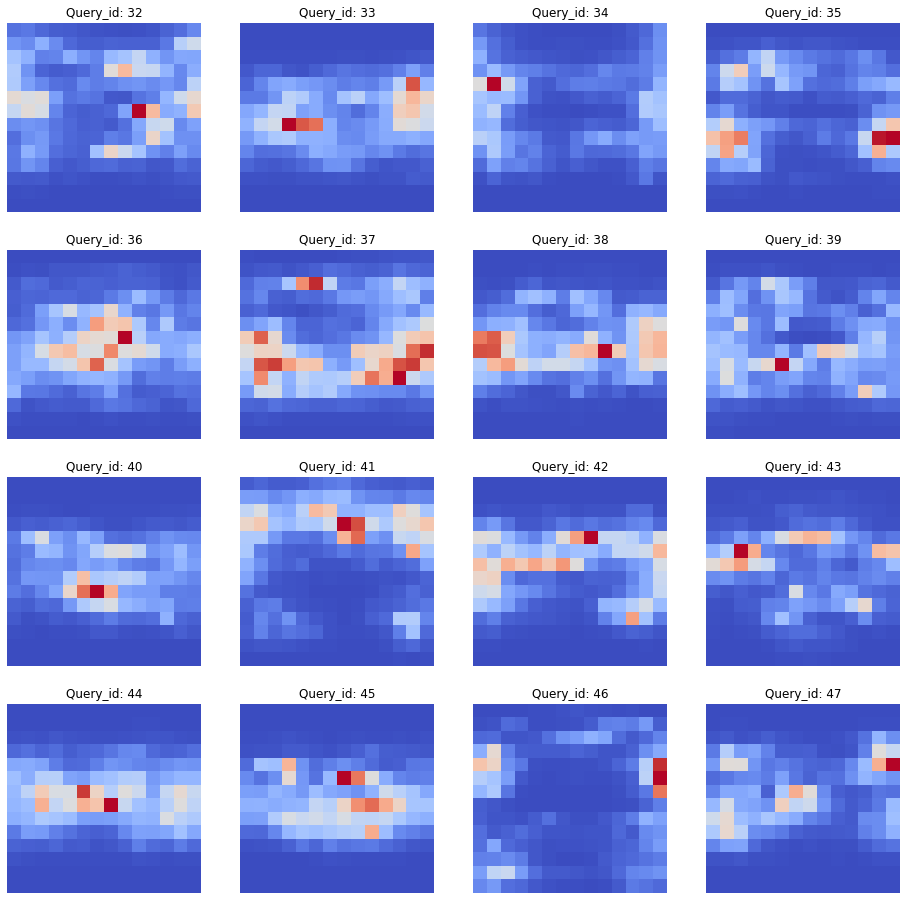

In [134]:
# id 32 - 47
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(32, 48):
    sns.heatmap(m_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-32], cbar = False)
    ax[i-32].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_masked_32_47.jpg"))

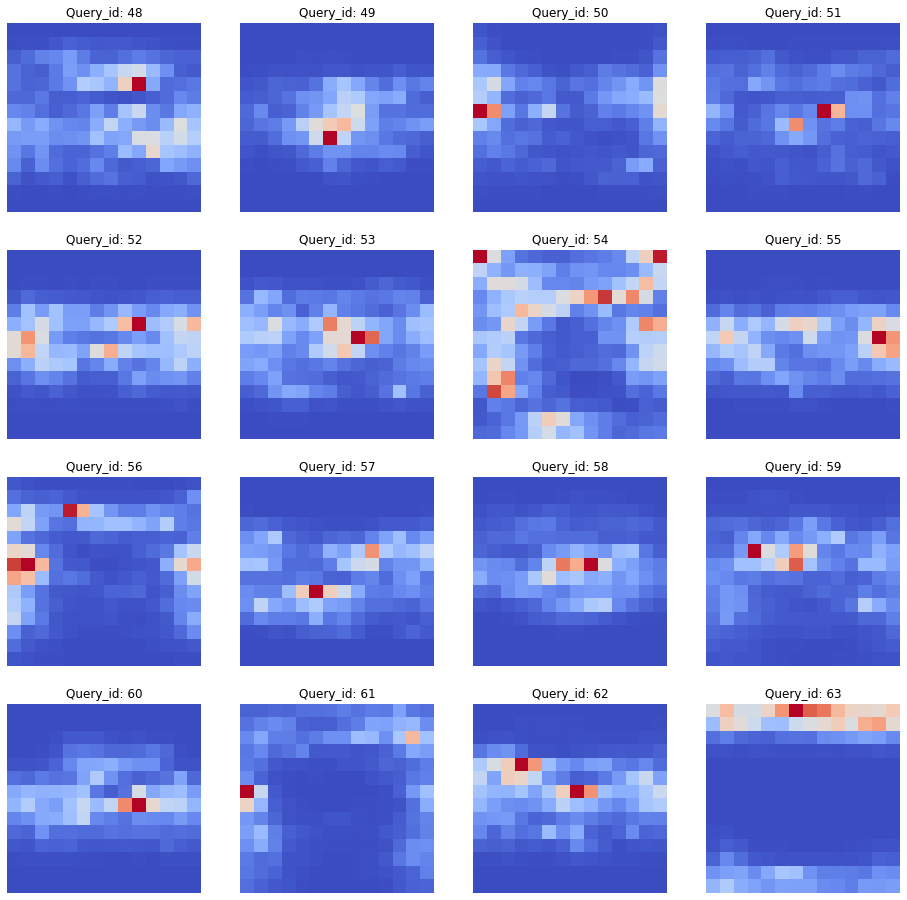

In [135]:
# id 48 - 63
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(48, 64):
    sns.heatmap(m_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-48], cbar = False)
    ax[i-48].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_masked_48_63.jpg"))

From visualization on various experiments, we found out that we are likely to get completely different attention weights on the first few epochs of training. This can be seen from experiment 1, 2, and 3 on DETR - Decoder only. 